In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import jax
from jax import numpy as jnp
from ott.solvers.quadratic import gromov_wasserstein
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import lower_bound
from ott.geometry import pointcloud, costs
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pickle
import seaborn as sns
G = 4.30219372e10 / 1e6

root_path = Path("../..")
data_path = root_path / "data"
halo_path = data_path / "halos.pkl"

In [15]:
subsampled = jnp.load(data_path / "kmeans_subsampled_n10_s50.npz")
points, halo_slice = pickle.load(open(halo_path, "rb"))
train_indices = np.loadtxt(data_path / "train_indices.txt").astype(int)
logc = jnp.log10(
    halo_slice["SubhaloVmax"]
    / jnp.sqrt(G * halo_slice["Group_M_Mean200"] / halo_slice["Group_R_Mean200"])
)

In [16]:
pts = subsampled["points"]
wghts = subsampled["weights"]

train_pts = pts[train_indices]
train_wghts = wghts[train_indices]
train_logc = logc[train_indices]

In [17]:
def preprocess_pts(pts):
    rec_pts = pts - pts.mean(axis=0, keepdims=True)
    norm_pts = rec_pts / 30
    return norm_pts

def gw_distance(pts_a, pts_b, wghts_a, wghts_b, epsilon=2e0):
    cloud_a = pointcloud.PointCloud(preprocess_pts(pts_a), cost_fn=costs.SqEuclidean())
    cloud_b = pointcloud.PointCloud(preprocess_pts(pts_b), cost_fn=costs.SqEuclidean())

    prob = quadratic_problem.QuadraticProblem(cloud_a, cloud_b, a=wghts_a, b=wghts_b)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=epsilon)

    return solver(prob)

t = 0
# soln = gw_distance(pts[5, t], pts[6, t], wghts[5, t], wghts[6, t])
trialed_gw_distance = jax.vmap(gw_distance)
dists_to_pointcloud = jax.jit(jax.vmap(trialed_gw_distance, in_axes=[0, None, 0, None]))
pairwise_dists = jax.jit(jax.vmap(dists_to_pointcloud, in_axes=[None, 0, None, 0]))

def self_pairwise_dists(pts, wghts):
    return pairwise_dists(pts, pts, wghts, wghts)

In [31]:
n_to_plot = 20
gw_dist_mat = self_pairwise_dists(train_pts[:n_to_plot, :], train_wghts[:n_to_plot, :])

In [32]:
logc_dist_mat = jnp.abs(train_logc[None, :n_to_plot] - train_logc[:n_to_plot, None])

<Axes: >

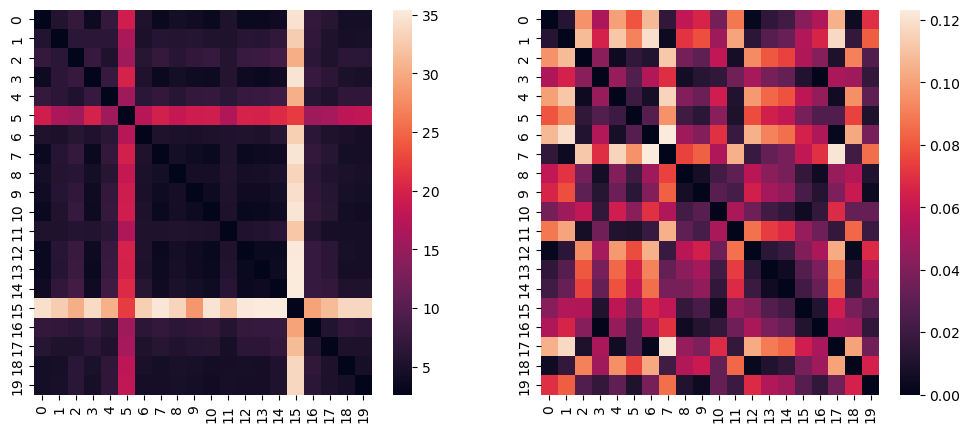

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(jnp.sqrt(jnp.median(gw_dist_mat.reg_gw_cost[:, :], -1)), ax=axs[0])
sns.heatmap(logc_dist_mat, ax=axs[1])

[(0.0, 10.0)]

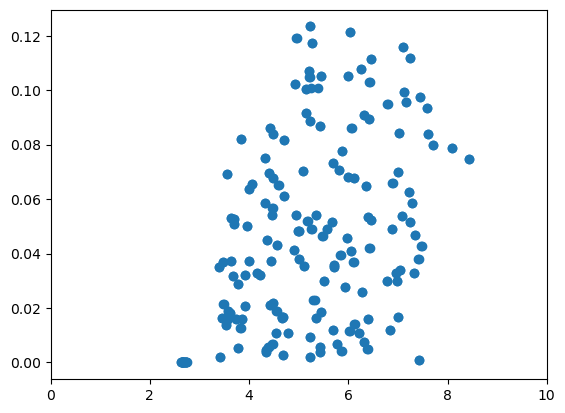

In [38]:
fig, ax = plt.subplots()
ax.scatter(jnp.sqrt(jnp.median(gw_dist_mat.reg_gw_cost[:, :], -1)).flatten(), logc_dist_mat.flatten())
ax.set(xlim=(0, 10))